INFO:__main__:Loading val dataset


/data/our_train.txt
/data/our_val.txt


INFO:__main__:Number of validation examples 6106
INFO:__main__:Loaded model weights from: ./models/ckpts/resnet_csra_fpn/resnet_csra_fpn_Acc_97.07_F1_95.68_pre_95.99_rec_95.45_step_19200.pth


backbone params inited by Pytorch official model


INFO:util:### Checkpoint weights that WILL be loaded: ###
INFO:util:### Checkpoint weights that CANNOT be loaded: ###
INFO:__main__:Number of validation examples 6106
INFO:__main__:Validation started...


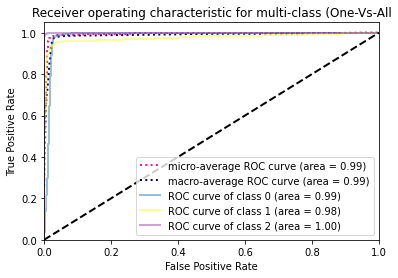

                   ________________________
                  |  Classification Report |
                   ‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1637
           1       0.95      0.90      0.92      1131
           2       1.00      1.00      1.00      3338

    accuracy                           0.97      6106
   macro avg       0.96      0.95      0.96      6106
weighted avg       0.97      0.97      0.97      6106



In [2]:
"""
Minimal prediction example
"""

import torch
from PIL import Image

from model.architecture import COVIDNext50
# from data.transforms import val_transforms
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from numpy import interp
from itertools import cycle
from prettytable import PrettyTable
from tqdm import tqdm
import json

import config
import os
import util
import numpy as np

import logging
from plot_metric.functions import MultiClassClassification

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

from data.dataset import COVIDxFolder
from data import transforms
from torch.utils.data import DataLoader
from model import architecture

log = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



def plot_roc_auc(mc,net):

    plt.figure()
    mc.plot_roc()

    roc_path = './results/'+net+'/roc/'
    if not os.path.exists(roc_path):
        os.makedirs(roc_path)
    roc_file = roc_path+ net+'_roc.png'
    plt.savefig(roc_file, format='png', dpi=1000)
    plt.show()
    plt.close()

def plot_pr(trues, preds,net):

    #roc
    # roc curve
    # fpr = dict()
    # tpr = dict()

    # for i in range(n_classes):
    #     fpr[i], tpr[i], _ = roc_curve(y_test[:, i],
    #                                   y_score[:, i]))
    #     plt.plot(fpr[i], tpr[i], lw=2, label='class {}'.format(i))

    # plt.xlabel("false positive rate")
    # plt.ylabel("true positive rate")
    # plt.legend(loc="best")
    # plt.title("ROC curve")
    # plt.show()
    # precision recall curve
    labels = [0,1,2]
    n_classes = len(labels)
    precision = dict()
    recall = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(trues[:, i],
                                                            preds[:, i])
        plt.plot(recall[i], precision[i], lw=2, label='Class {}'.format(i))
        
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend(loc="best")
    plt.title("Precision vs. Recall curve")
    plt.show()
    pr_path = './results/'+net+'/pr/'
    if not os.path.exists(pr_path):
        os.makedirs(pr_path)
    pr_file = pr_path+'roc.png'
    plt.savefig(pr_file, format='png', dpi=1000)
    plt.close()

def plot_confusionmatrix(mc,net):
    # plt.subplot(132)
    plt.figure()
    mc.plot_confusion_matrix()
    # plt.subplot(133)
    # mc.plot_confusion_matrix(normalize=True)


    metrix_path = './results/'+net+'/confusion_matrices/'
    if not os.path.exists(metrix_path):
        os.makedirs(metrix_path)
    pr_file = metrix_path+'confusion_matrices.png'
    plt.savefig(pr_file, format='png', dpi=1000)
    plt.close()


def get_specifity(confusionmatrix,net):
    classes=['Normal','Pneumonia','COVID-19']
    # precision, recall, specificity
    table = PrettyTable()
    table.field_names = ["", "Precision", "Recall", "Specificity"]
    sum_spec =0
    for i in range(3):
        TP = confusionmatrix[i, i]
        FP = np.sum(confusionmatrix[:, i]) - TP
        FN = np.sum(confusionmatrix[i, :]) - TP
        TN = confusionmatrix[0,0]+confusionmatrix[1,1]+confusionmatrix[2,2] - TP 
        
        Precision = round(TP / (TP + FP), 3) if TP + FP != 0 else 0.
        Recall = round(TP / (TP + FN), 3) if TP + FN != 0 else 0.
        Specificity = round(TN / (TN + FP), 3) if TN + FP != 0 else 0.
        sum_spec+=Specificity
        table.add_row([classes[i], Precision, Recall, Specificity])
    print(table)
    print("model specificity：{}",sum_spec/3)
    

def evaluate(net,train_loader,data_loader, model, best_score, global_step, cfg):
    global bestacc
    model.eval()

    gts, predictions = [], []
    log.info("Validation started...")
    for data in data_loader:
        imgs, labels = data
        imgs = util.to_device(imgs, gpu=cfg.gpu)

        with torch.no_grad():
            logits = model(imgs)
            # print(logits)
            # probs = model.module.probability(logits)
            # preds = torch.argmax(probs, dim=1).cpu().numpy()

        logits = logits.cpu().detach().numpy()
        labels = labels.cpu().detach().numpy()

        predictions.extend(logits)
        gts.extend(labels)

    predictions = np.array(predictions)
    gts = np.array(gts, dtype=np.int32)

    # Visualisation with plot_metric :
    mc = MultiClassClassification(gts, predictions, labels=[0, 1, 2])

    # #specifity
    # get_specifity(mc,net)

    plot_roc_auc(mc,net)

    # plot_pr(gts, predictions,net)
    
    plot_confusionmatrix(mc,net)

    mc.print_report()    #PR曲线

    return best_score
    # return predictions

def main(net):
    log.info("Loading val dataset")
    train_dataset = COVIDxFolder(config.train_imgs, config.train_labels,
                                    transforms.train_transforms(config.width,
                                                                config.height))
    train_loader = DataLoader(train_dataset,
                            batch_size=config.batch_size,
                            shuffle=True,
                            drop_last=True,
                            num_workers=config.n_threads,
                            pin_memory=use_gpu)  

    val_dataset = COVIDxFolder(config.val_imgs, config.val_labels,
                                transforms.val_transforms(config.width,
                                                            config.height))
    val_loader = DataLoader(val_dataset,
                            batch_size=config.batch_size,
                            shuffle=False,
                            num_workers=config.n_threads,
                            pin_memory=use_gpu)
    log.info("Number of validation examples {}".format(len(val_dataset)))

    if net =='resnet50-nocutmix':
        weight = config.weights[0]
    if net =='resnet50':
        weight = config.weights[1]
    if net == 'resnet_csra':
        weight = config.weights[2]
    if net == 'resnet_csra_fpn':
        weight = config.weights[3]
    if net == 'vit':
        weight =  config.weights[4]
    if net == 'vit_csra':
        weight =  config.weights[5]
    # if net == 'vit_MCRA':
    #     weight = config.weights[6]
    if net == 'swin':
        weight =  config.weights[6]
    if net == 'swin_csra':
        weight =  config.weights[7]
    if net == 'cswin':
        weight =  config.weights[8]
    if net == 'convnext':
        weight =  config.weights[9]
    if net == 'convmixer':
        weight =  config.weights[10]
    if net == 'poolformer':
        weight =  config.weights[11]
    
    if weight:
        state = torch.load(weight)
        # state = None
        log.info("Loaded model weights from: {}".format(weight))
    else:
        state = None

    state_dict = state["state_dict"] if state else None
    model = architecture.COVIDNext50(net=net,n_classes=config.n_classes)
    if state_dict:
        model = util.load_model_weights(model=model, state_dict=state_dict)

    if use_gpu:
        model.cuda()
        model = torch.nn.DataParallel(model)

    log.info("Number of validation examples {}".format(len(val_dataset)))

    evaluate(net,train_loader,val_loader,model,best_score=0,global_step=0,cfg=config)

if __name__ == '__main__':
    seed = config.random_seed
    if seed:
        np.random.seed(seed)
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)

    if config.gpu and not torch.cuda.is_available():
        raise ValueError("GPU not supported or enabled on this system.")
    use_gpu = config.gpu
    
    # main(net = 'resnet50-nocutmix')
    # main(net = 'resnet50')
    # main(net = 'resnet_csra')
    main(net = 'resnet_csra_fpn')
    # main(net = 'vit')
    # main(net = 'vit_csra')
    # main(net = 'swin')
    # main(net = 'swin_csra')
    # main(net = 'cswin')
    # main(net = 'convnext')
    # main(net = 'convmixer')
    # main(net = 'poolformer')




